# HR analytics basic Feature Engineering baselining 
 
 Machine Learning 2 - Assignment 1 - Professor Jesus Salvador Renero Quintero

 This notebook will illustrate how to build a basic pipeline for a regression problem. 

# Imports 

In [219]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV


from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import  RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
from pandas.core import datetools

from pandas import DataFrame 
from gplearn.genetic import SymbolicTransformer

warnings.simplefilter(action='ignore')



# Functions for Data Preparation  

In [220]:
## Reading the data: 
def read_data(input_path):
    raw_data = pd.read_csv(input_path, keep_default_na=False, na_values=['_'])
    return raw_data


## Fixing desired types:
def fix_types(df):
    df['Work_accident'] = df['Work_accident'].astype('category') 
    df['promotion_last_5years'] = df['promotion_last_5years'].astype('category') 
    df['left'] = df['left'].astype('category')
    df['sales'] = df['sales'].astype('category') 
    df['salary'] = df['salary'].astype('category') 
    df['time_spend_company']= df['time_spend_company'].astype('category')
    df['number_project']= df['number_project'].astype('category')
    return df


## One hot encoding of the desired categorical columns:
def onehot_encode(df):
    category=['sales','salary']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df


## Checking the features for which we will fix the skewness:

def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features


## Fixing the skewness of the features selected:

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df


## Scaling numerical features
def feature_scaling(df):
    numeric_dtypes = ['int16', 'int32', 'int64',
                          'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric_features.append(i)
    df[numeric_features]= preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(df[numeric_features])
    return df


# Getting the correlation for the numeric variables:

def correlation_spear(df):
    numeric_dtypes = ['int16', 'int32', 'int64',
                          'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric_features.append(i)
    corr= stats.spearmanr(df[numeric_features])
    return pd.DataFrame(corr[0], columns=numeric_features,index= numeric_features)

# Functions for Feature Engineering 

In [221]:
## Grouping the 2,7,8,10 years in time spend in the company after analysing the plot because it looks like they behave in the same way
## whereby the ones who started work (2years) and the ones who stay in the company for many years (7,8,10 years) are loyal to the company 
## hence they are the ones that are most likely to stay in the company 

def group_time_spend(dataset):
    df=dataset.copy()
    df['time_groups']= df.time_spend_company.apply(
               lambda x: (1 if x in [2,7,8,10] else x)).astype('category')
    df = df.drop('time_spend_company',axis=1)
    category=['time_groups']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df


## Grouping the 2,6,7 projects in number of project after analysing the plot 
## because it seems that the employee attrition is the same, making the whole column as a category and then dummyfying

def group_number_projects(dataset):
    df=dataset.copy()
    df['group_project']= df.number_project.apply(
               lambda x: (1 if x in [2,6,7] else x)).astype('category')
    df = df.drop('number_project',axis=1)
    category=['group_project']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df


## Grouping the following departments because they are small and seem to behave the same

def group_depts(dataset):
    df=dataset.copy()
    to_group=['sales_product_mng','sales_RandD','sales_marketing','sales_accounting','sales_management','sales_hr']
    df['group_depts']=df.apply(lambda i : i.sales_product_mng +i.sales_RandD + i.sales_marketing+i.sales_accounting+i.sales_management +i.sales_hr, axis=1).astype('category')
    df.drop(to_group,axis=1)
    return df


## Remove outliers:

def remove_outliers(df):
    X = df.drop(['left'], axis=1)
    y = df.left.reset_index(drop=True)
    ols = sm.OLS(endog = np.asarray(y,dtype='float'), exog = np.asarray(X,dtype='float'))
    fit = ols.fit()
    test = fit.outlier_test()['bonf(p)']
    outliers = list(test[test<1e-3].index) 
    df.drop(df.index[outliers])
    return df
    
    
## Bining or grouping the different satisfaction levels

def bin_satisfaction_level(dataset):
    df = dataset.copy()
    bins = [0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0]
    df['satisfaction_level_bin'] = pd.cut(df['satisfaction_level'],bins).astype('category')
    df = df.drop('satisfaction_level',axis=1)
    category=['satisfaction_level_bin']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    
    return new_df


## Grouping the average_monthly_hours 

def bin_average_monthly_hours(dataset):  
    df = dataset.copy()
    bins = [96, 131, 165, 178, 179, 259, 287]
    df['average_montly_hours_bin'] = pd.cut(df['average_montly_hours'],bins).astype('category')
    df = pd.concat([df, pd.get_dummies(df['average_montly_hours_bin'],prefix='am', prefix_sep='_')], axis=1)
    df = df.drop('average_montly_hours', axis=1)
    category=['average_montly_hours_bin']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    
    return new_df


## Bining the employees based on their performance
def bin_last_evaluation(dataset):
    df = dataset.copy()
    bins = [0, 0.48, 0.65, 0.89,1.0]
    df['last_evaluation_bin'] = pd.cut(df['last_evaluation'],bins).astype('category')
    df = pd.concat([df, pd.get_dummies(df['last_evaluation_bin'],prefix='am', prefix_sep='_')], axis=1)
    df = df.drop('last_evaluation', axis=1)
    category=['last_evaluation_bin']
    numericals = df.get(list(set(df.columns) - set(category)))
    new_df = numericals.copy()
    for categorical_column in category:
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    
    return new_df


## Use Genetic Programming to create new variables and add them to the columns of the dataset 

def Genetic_P(dataset):
    y = dataset['left']
    X=dataset.copy()
    X=X.drop('left',axis=1)
    function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
    gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=15,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=100, n_jobs=3)
    gp_features = gp.fit_transform(X,y)
    new_X = pd.concat([pd.DataFrame(gp_features),dataset],axis=1)
    return new_X

def relative_satisfaction_salary(data):
    raw_data = read_data('turnover.csv')
    n  = (raw_data.groupby(['salary'], as_index=False).mean()
                .groupby('salary')['satisfaction_level'].mean())
    m = (raw_data.groupby(['salary'], as_index=True).std()['satisfaction_level'])
    df = raw_data.join(n, on='salary',rsuffix='_average').join(m, on='salary',rsuffix='_std')
    df.eval("relative_satisfaction = (satisfaction_level - satisfaction_level_average) / satisfaction_level_std",inplace=True)
    new  = pd.concat([data, df['relative_satisfaction']], axis=1).copy()
    return new

def bin_relative_satisfaction(dataset):
    bins = [-2.42, -1.9, -1.1, -0.46, 0.4, 1.26]
    dataset['Relative_satisfaction_level_bin'] = pd.cut(dataset.relative_satisfaction,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['Relative_satisfaction_level_bin'],prefix='sts', prefix_sep='_')], axis=1)
    dataset.drop('relative_satisfaction', inplace=True, axis=1)
    dataset.drop('Relative_satisfaction_level_bin', inplace=True, axis=1)
    return dataset

def relative_working_hours_salary(data):
    raw_data = read_data('turnover.csv')
    n  = (raw_data.groupby(['salary'], as_index=False).mean()
                .groupby('salary')['average_montly_hours'].mean())
    m = (raw_data.groupby(['salary'], as_index=True).std()['average_montly_hours'])
    df = raw_data.join(n, on='salary',rsuffix='_average').join(m, on='salary',rsuffix='_std')
    df.eval("relative_average_montly_hours = (average_montly_hours - average_montly_hours_average) /average_montly_hours_std",inplace=True)
    new  = pd.concat([data, df['relative_average_montly_hours']], axis=1).copy()
    return new

def bin_relative_work_hours(dataset):
    bins = [-1.53, -0.71, 0.8, 1.55, 2.25]
    dataset['relative_average_montly_hours_bin'] = pd.cut(dataset.relative_average_montly_hours,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['relative_average_montly_hours_bin'],prefix='sts', prefix_sep='_')], axis=1)
    dataset.drop('relative_average_montly_hours', inplace=True, axis=1)
    dataset.drop('relative_average_montly_hours_bin', inplace=True, axis=1)
    return dataset

def relative_last_evaluation_salary(data):
    raw_data = read_data('turnover.csv')
    n  = (raw_data.groupby(['salary'], as_index=False).mean()
                .groupby('salary')['last_evaluation'].mean())
    m = (raw_data.groupby(['salary'], as_index=True).std()['last_evaluation'])
    df = raw_data.join(n, on='salary',rsuffix='_average').join(m, on='salary',rsuffix='_std')
    df.eval("relative_last_evaluation = (last_evaluation - last_evaluation_average) /last_evaluation_std",inplace=True)
    new  = pd.concat([data, df['relative_last_evaluation']], axis=1).copy()
    return new

def bin_relative_last_eval(dataset):
    bins = [-1.57,-.845,0.24,0.91,1.81]
    dataset['relative_last_evaluation_level_bin'] = pd.cut(dataset.relative_last_evaluation,bins)
    dataset = pd.concat([dataset, pd.get_dummies(dataset['relative_last_evaluation_level_bin'],prefix='sts', prefix_sep='_')], axis=1)
    dataset.drop('relative_last_evaluation', inplace=True, axis=1)
    dataset.drop('relative_last_evaluation_level_bin', inplace=True, axis=1)
    return dataset


# Functions to apply the model, the pipelines and the function for Cross Validation 

In [222]:

def log_reg(dataset):
    target='left'
    X = dataset.loc[:, dataset.columns != target]
    y = dataset.loc[:, target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=100)
    logreg = LogisticRegression(solver='lbfgs',max_iter=250)
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    ##print('Accuracy on test: {:.2f}'.format(logreg.score(X_test, y_test)))
    ##print(confusion_matrix(y_test, y_pred))
    ##print(classification_report(y_test, y_pred))
    return logreg.score(X_test, y_test)



def cv_evaluate(df, splits=10):
    logreg = LogisticRegression(solver='lbfgs',max_iter=250)
    kfolds = KFold(n_splits=splits, shuffle=True, random_state=100)

    X = df.drop(['left'],axis=1)
    y = df.loc[:, 'left']
    benchmark_model = make_pipeline( logreg).fit(X=X, y=y)
    scores = cross_val_score(benchmark_model, X, y, scoring='accuracy', cv=kfolds)
    
    return scores



def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score  = np.mean(cv_evaluate(raw_data))
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score  = np.mean(cv_evaluate(processed_data))
        print('- New mean Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > -0.01:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions , engineered_data 


def get_best_fit(X_train, y_train, K):

    kf = KFold(n_splits=K, shuffle=True, random_state=100)

    old_Kscore=0
    accuracy = []
    k=0
    for train_index, val_index in kf.split(X_train, y_train):
        k+=1
        X_tra, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tra, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # instantiate model
        logreg = LogisticRegression(solver='lbfgs',max_iter=250)
        
        #calculate errors
        L = logreg.fit(X_tra, y_tra)
        y_pred = logreg.predict(X_val)
        Kscore = logreg.score(X_val, y_val)
    
        difference = (Kscore-old_Kscore)
        print('[diff: {:.4f}] '.format(Kscore), end='')
        if Kscore > old_Kscore:
            L_fit = L
            old_Kscore = Kscore.copy()
            b_k= k
            print('changed')
            accuracy.append(Kscore)
    print('The highest accuracy score from the K_folds obtained at K: {:.3f} id {:.3f}'.format(b_k,old_Kscore))
    return Kscore, L_fit

# Data Loading and fix the types 

In [223]:
raw_data = read_data('turnover.csv')
prepared = fix_skewness(fix_types((raw_data).copy()))
print('Original shape before onehot encoding: {}'.format(prepared.shape))


Original shape before onehot encoding: (14999, 10)


In [224]:
prepared.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

# Data Preparation 

In [225]:
dataset = onehot_encode(prepared)
print('Dataset shape AFTER onehot encoding: {}'.format(dataset.shape))

Dataset shape AFTER onehot encoding: (14999, 21)


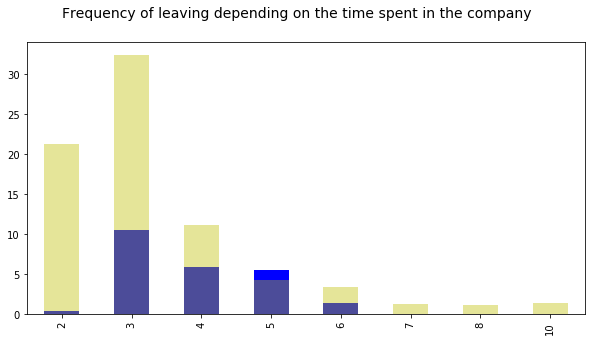

In [226]:
## Bar chart representing the number of employees and the time spent within the company with color blue meaning that they left and yellow referring to the employees that stayed within the company 

fig = plt.figure(figsize=(10,5))
fig.suptitle('Frequency of leaving depending on the time spent in the company', fontsize=14)
((dataset[dataset.left==1].time_spend_company.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='b')
((dataset[dataset.left==0].time_spend_company.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='y',alpha=0.4)


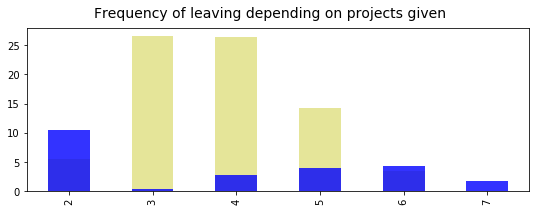

In [227]:
## Bar chart indicating the frequency of employees leaving depending on the projects

fig = plt.figure(figsize=(9,3))
fig.suptitle('Frequency of leaving depending on projects given', fontsize=14)

((dataset[dataset.left==0].number_project.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='y', alpha=0.4)
((dataset[dataset.left==1].number_project.value_counts().sort_index()/len(dataset.left))*100).plot(kind='bar',color='b',alpha=0.8)

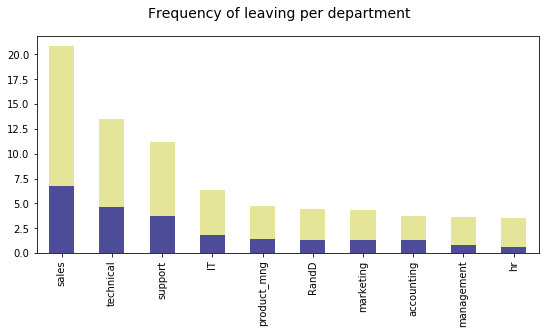

In [228]:
## Bar chart representing the value of the sales within each different department and the employee attrition accordingly

fig = plt.figure(figsize=(9,4))
fig.suptitle('Frequency of leaving per department', fontsize =14)

((raw_data[raw_data.left==1].sales.value_counts()/len(raw_data.left))*100).plot(kind='bar',color='b')
((raw_data[raw_data.left==0].sales.value_counts()/len(raw_data.left))*100).plot(kind='bar',color='y',alpha=0.4)

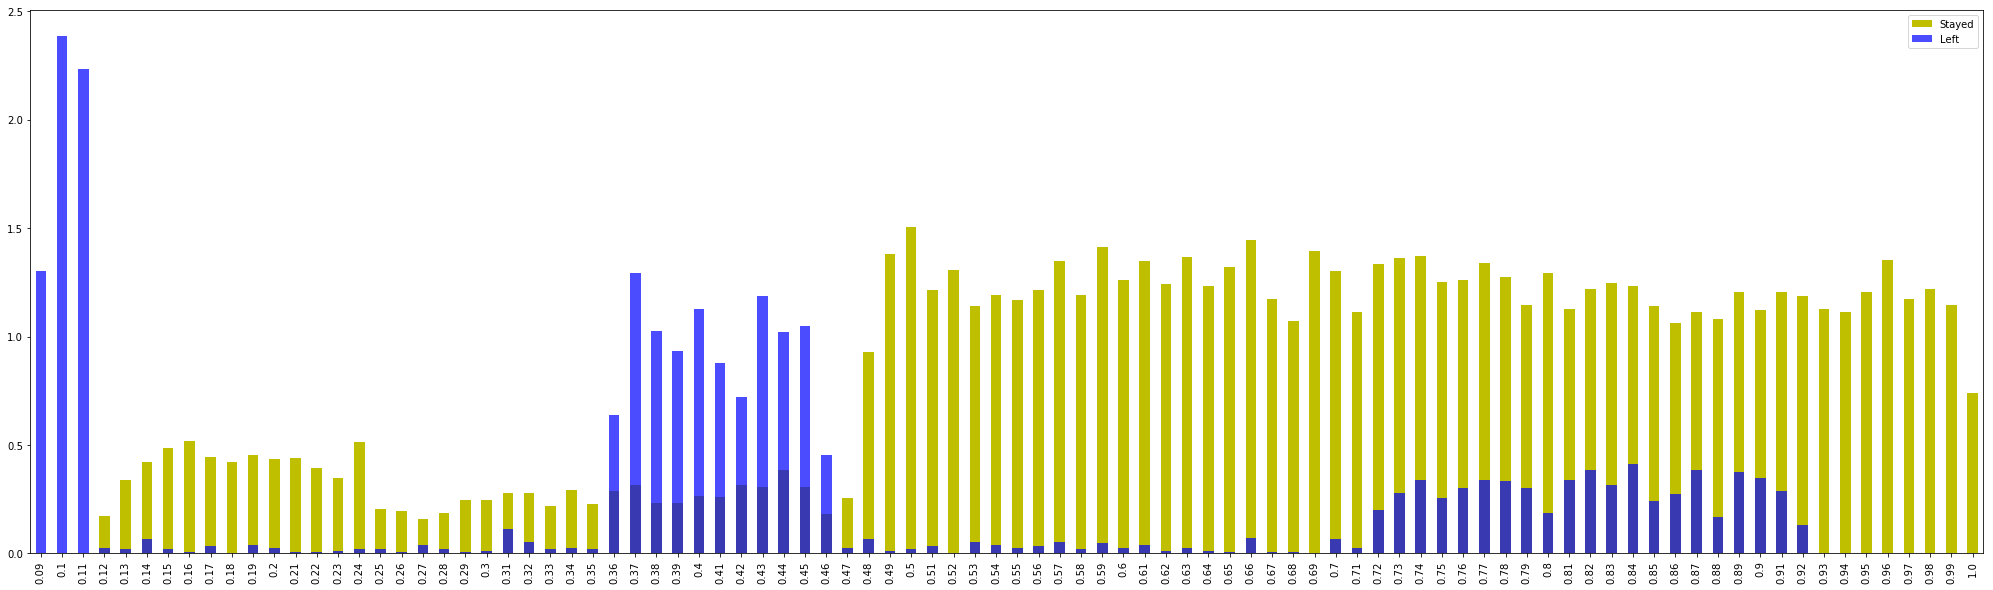

In [229]:
# Seeing the different satisfaction levels 
# Using different colors to differentiate between the satisfaction levels depending on employee attrition  

dataset.satisfaction_level = dataset.satisfaction_level.astype('category')
ax = pd.Series((dataset[dataset.left==0].satisfaction_level.value_counts()/len(dataset.left))*100).sort_index().plot(kind='bar',color='y',figsize=(35,10))
pd.Series((dataset[dataset.left==1].satisfaction_level.value_counts()/len(dataset.left))*100).sort_index().plot(kind='bar',color='b',alpha= 0.7,figsize=(35,10), ax=ax)
ax.legend(["Stayed", "Left"])

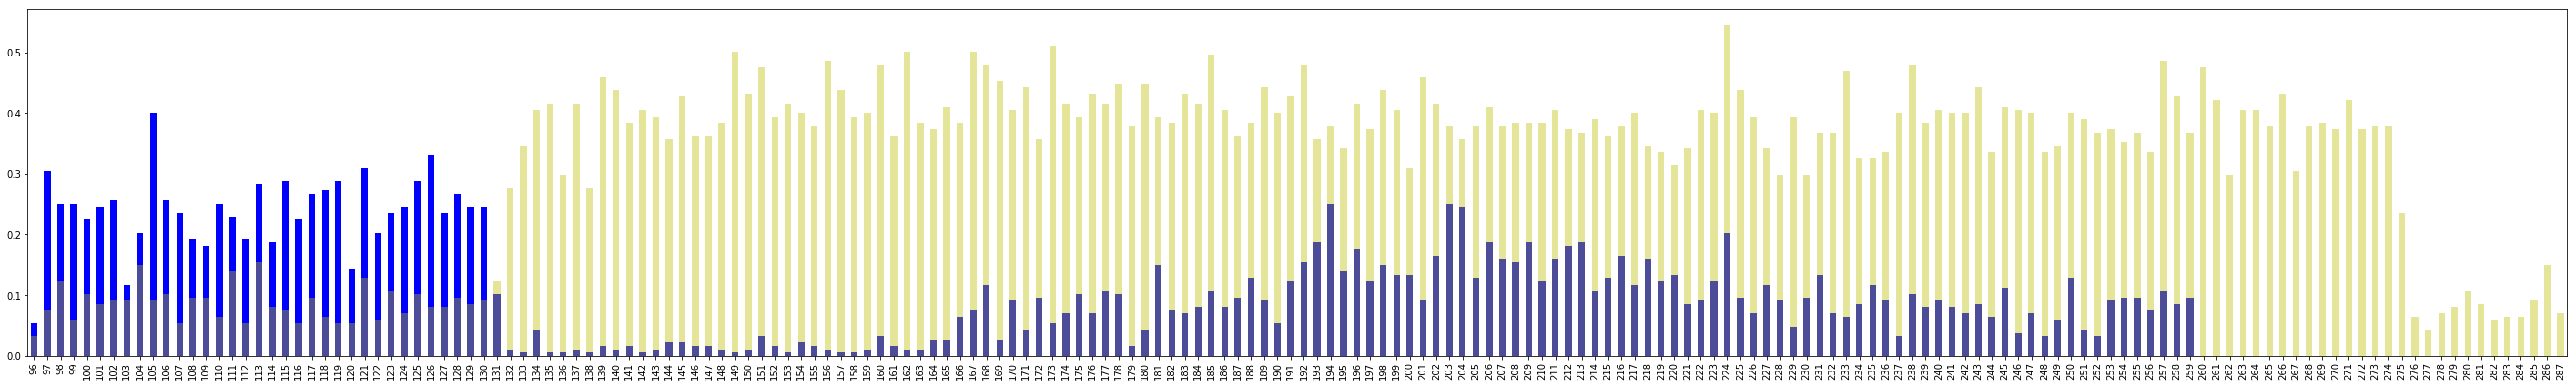

In [230]:
## Representing the distribution of employees based on the average monthly hours spent at the company 

plt.figure(figsize=(50,7))
((dataset[dataset.left==1].average_montly_hours.value_counts().sort_index()/len(dataset.left))*80).plot(kind='bar',color='b')
((dataset[dataset.left==0].average_montly_hours.value_counts().sort_index()/len(dataset.left))*80).plot(kind='bar',color='y',alpha=0.4)

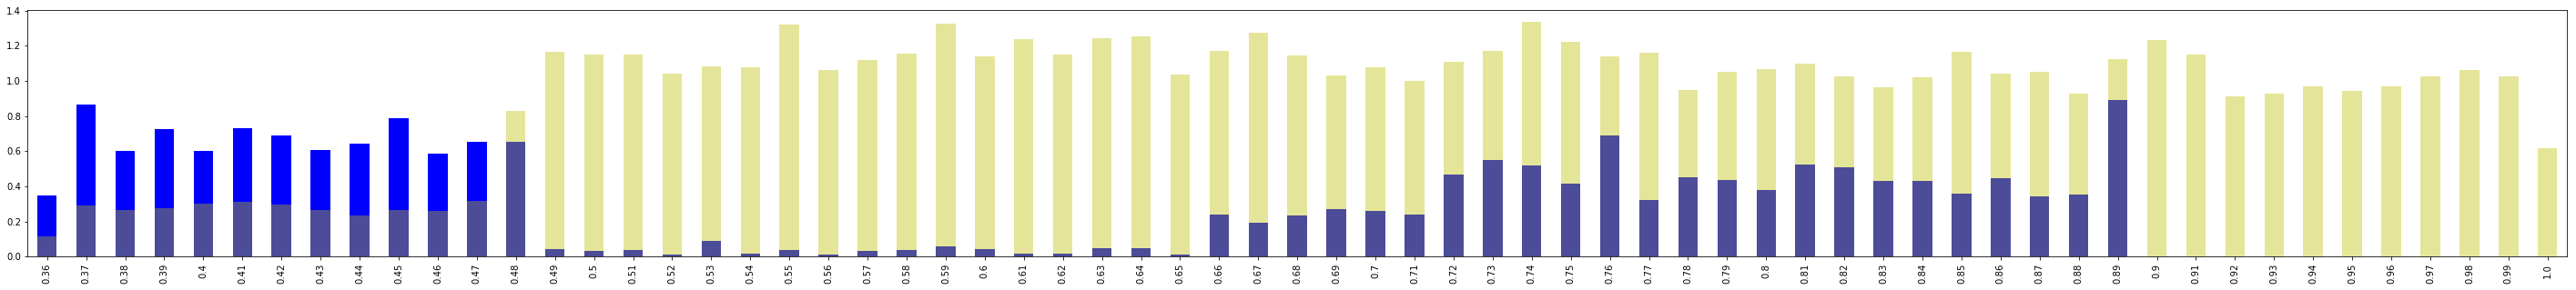

In [231]:
## Representing the distribution of employees based on their performance 

plt.figure(figsize=(50,5))
((dataset[dataset.left==1].last_evaluation.value_counts().sort_index()/len(dataset.left))*80).plot(kind='bar',color='b')
((dataset[dataset.left==0].last_evaluation.value_counts().sort_index()/len(dataset.left))*80).plot(kind='bar',color='y',alpha=0.4)

In [232]:
to_analyze = relative_last_evaluation(relative_satisfaction_salary(relative_working_hours_salary(prepared)))


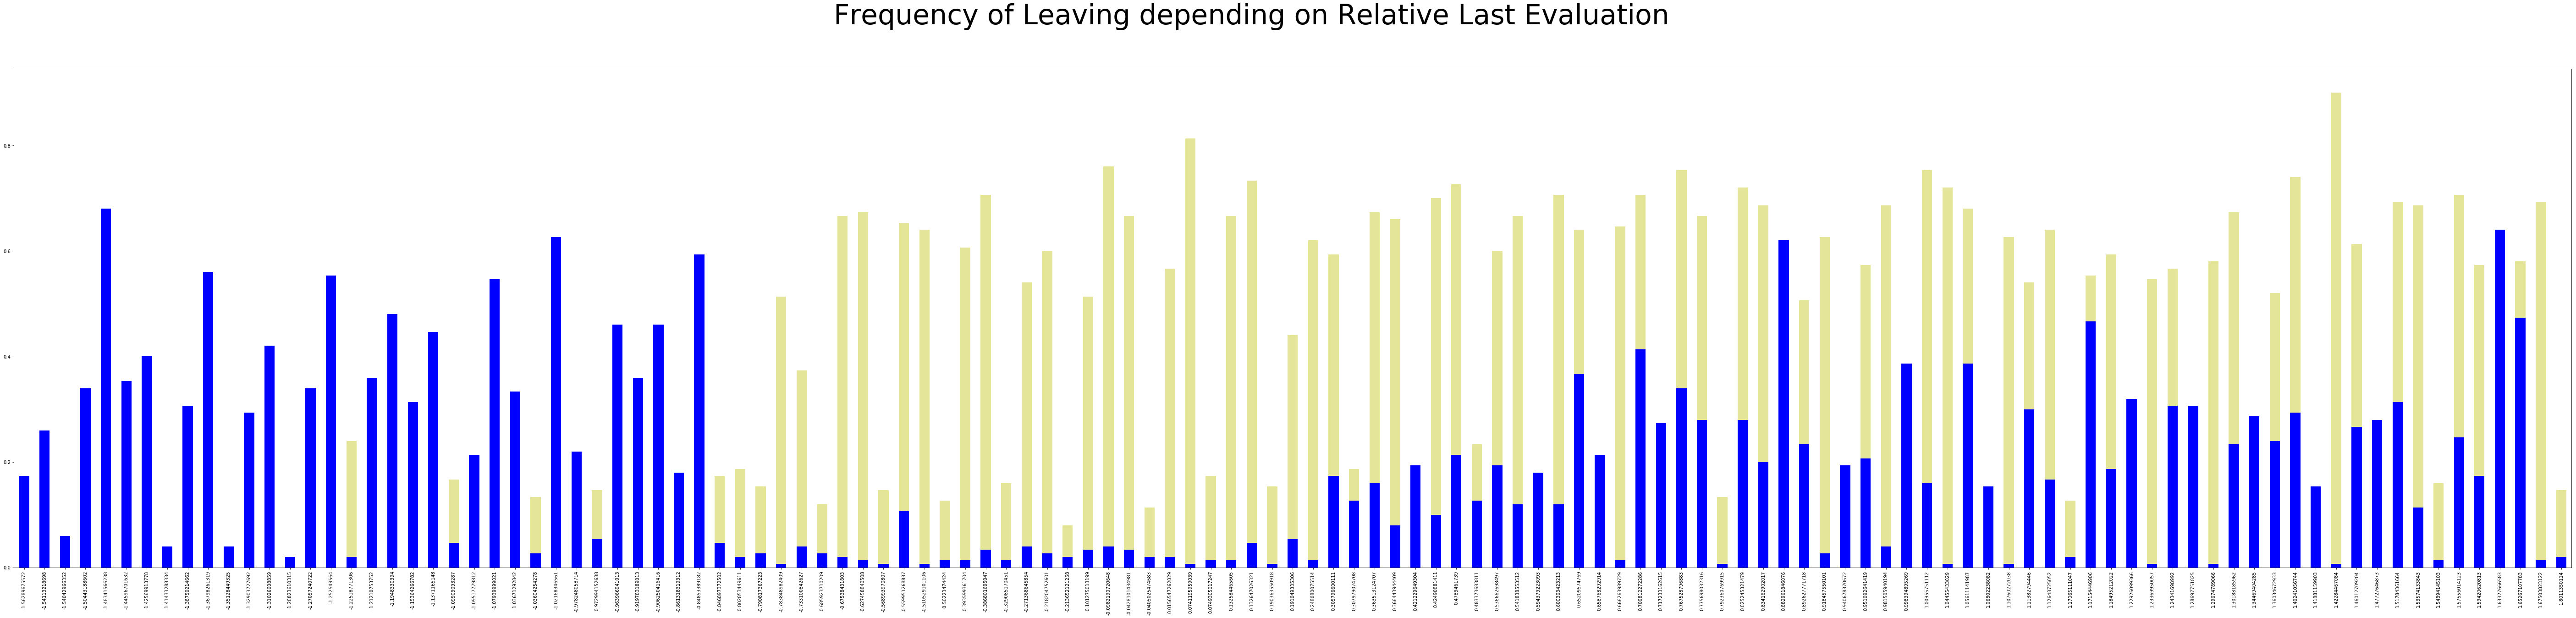

In [233]:

fig = plt.figure(figsize=(100,20))
fig.suptitle('Frequency of Leaving depending on Relative Last Evaluation', fontsize=60)
((to_analyze[to_analyze.left==0].relative_last_evaluation.value_counts().sort_index()/len(to_analyze.left))*100).plot(kind='bar',color='y',alpha=0.4)
((to_analyze[to_analyze.left==1].relative_last_evaluation.value_counts().sort_index()/len(to_analyze.left))*100).plot(kind='bar',color='b')

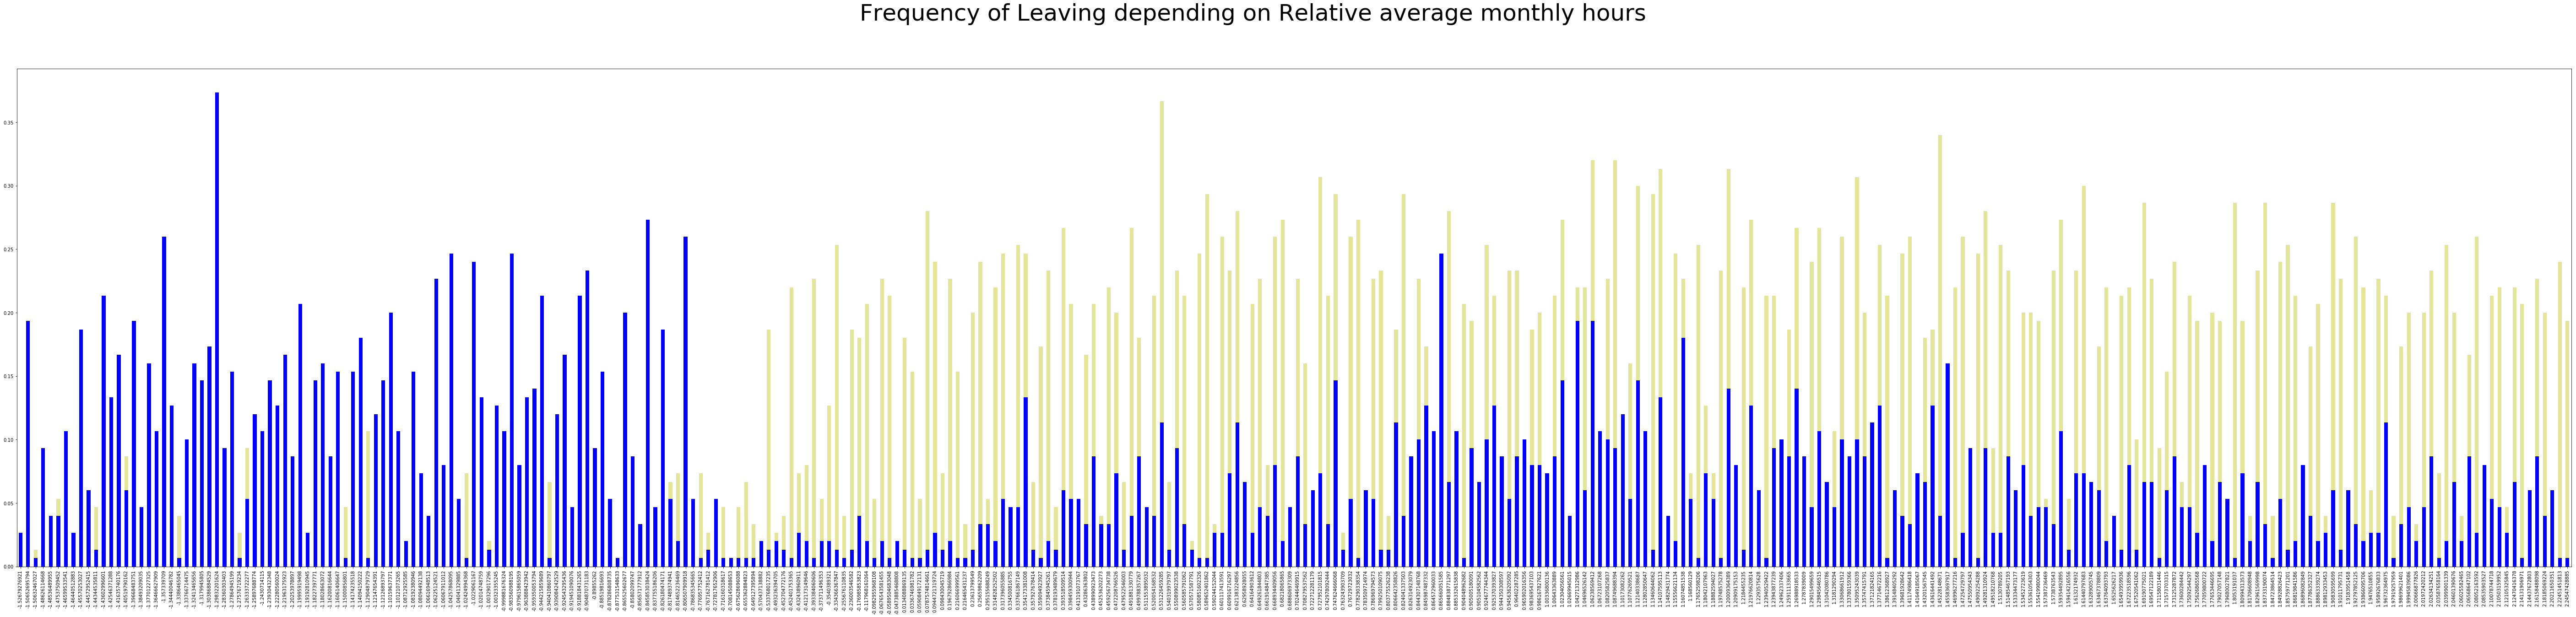

In [234]:
fig = plt.figure(figsize=(100,20))
fig.suptitle('Frequency of Leaving depending on Relative average monthly hours', fontsize=50)
((to_analyze[to_analyze.left==0].relative_average_montly_hours.value_counts().sort_index()/len(to_analyze.left))*100).plot(kind='bar',color='y',alpha = 0.4)
((to_analyze[to_analyze.left==1].relative_average_montly_hours.value_counts().sort_index()/len(to_analyze.left))*100).plot(kind='bar',color='b')

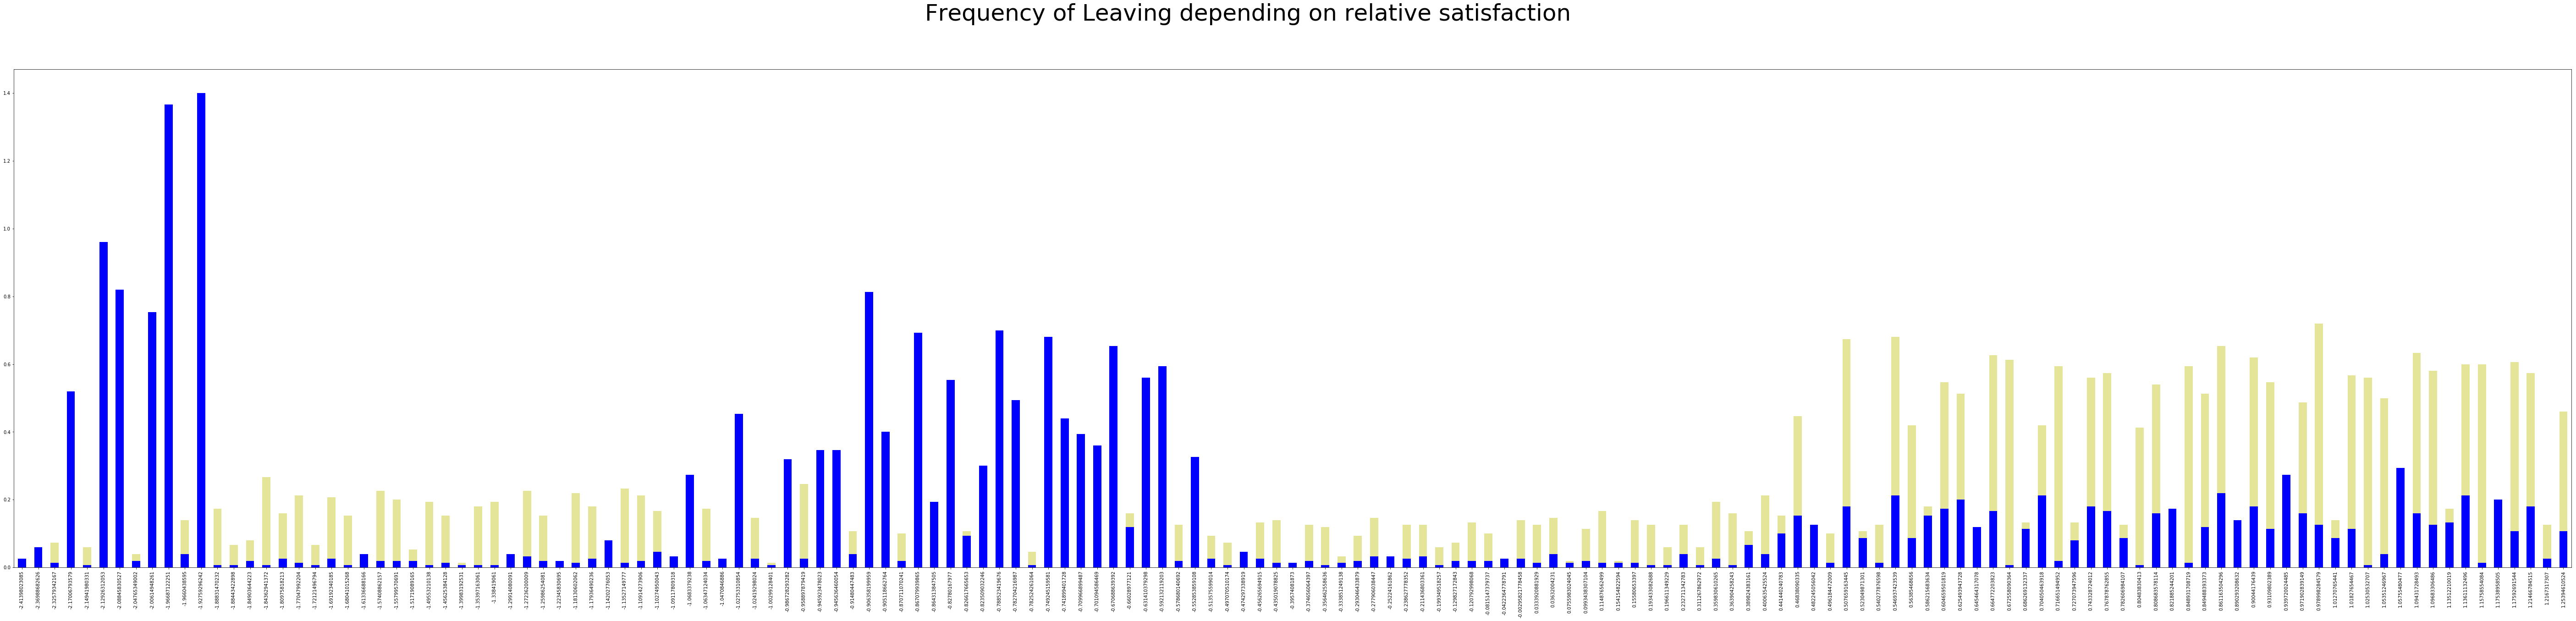

In [235]:
fig = plt.figure(figsize=(100,20))
fig.suptitle('Frequency of Leaving depending on relative satisfaction ', fontsize=50)
((to_analyze[to_analyze.left==0].relative_satisfaction.value_counts().sort_index()/len(to_analyze.left))*100).plot(kind='bar',color='y',alpha = 0.4)
((to_analyze[to_analyze.left==1].relative_satisfaction.value_counts().sort_index()/len(to_analyze.left))*100).plot(kind='bar',color='b')

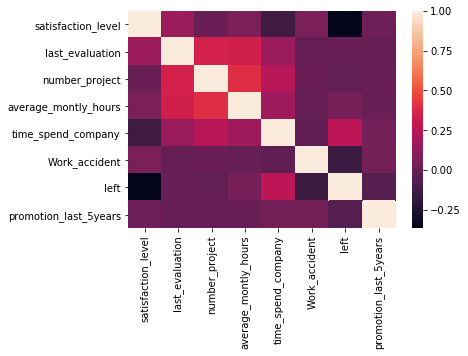

In [236]:
corr = correlation_spear(raw_data)

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


In [237]:
corr

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.162407,0.005786,0.062000,-0.139428,0.056333,-0.365842,0.022306
last_evaluation,0.162407,1.000000,0.350399,0.342061,0.161154,-0.005767,-0.002440,-0.007167
number_project,0.005786,0.350399,1.000000,0.397855,0.251971,0.002328,-0.019544,-0.002960
average_montly_hours,0.062000,0.342061,0.397855,1.000000,0.168750,-0.006063,0.046455,-0.002951
time_spend_company,-0.139428,0.161154,0.251971,0.168750,1.000000,-0.027277,0.268876,0.035205
Work_accident,0.056333,-0.005767,0.002328,-0.006063,-0.027277,1.000000,-0.154622,0.039245
left,-0.365842,-0.002440,-0.019544,0.046455,0.268876,-0.154622,1.000000,-0.061788
promotion_last_5years,0.022306,-0.007167,-0.002960,-0.002951,0.035205,0.039245,-0.061788,1.000000


# Baseline Model 

In [238]:
## Applying a logistic regression on the initial dataset with 80/20 split 

score = log_reg(dataset)
print('My baseline score is: {}'.format(score))

My baseline score is: 0.7873333333333333


# Feature Engineering

In [239]:
fe_functions=['relative_satisfaction_salary',
              'relative_working_hours_salary',
              'relative_last_evaluation_salary',
              'bin_relative_last_eval',
              'bin_relative_work_hours',
              'bin_relative_satisfaction',
              'group_time_spend',
              'group_depts',
              'group_number_projects',
              'feature_normalizing'
              , 'bin_satisfaction_level'
              , 'bin_average_monthly_hours'
              ,'bin_last_evaluation',
             'Genetic_P']

functions_selected , engineered_data = feature_engineering_pipeline(dataset, fe_functions)

Base Score: 0.7922
- New mean Score (relative_satisfaction_salary): 0.7897 [diff: -0.0025] [Accepted]
- New mean Score (relative_working_hours_salary): 0.7909 [diff: 0.0011] [Accepted]
- New mean Score (relative_last_evaluation_salary): 0.7911 [diff: 0.0003] [Accepted]
- New mean Score (bin_relative_last_eval): 0.8413 [diff: 0.0502] [Accepted]
- New mean Score (bin_relative_work_hours): 0.8715 [diff: 0.0302] [Accepted]
- New mean Score (bin_relative_satisfaction): 0.9096 [diff: 0.0381] [Accepted]
- New mean Score (group_time_spend): 0.9423 [diff: 0.0327] [Accepted]
- New mean Score (group_depts): 0.9420 [diff: -0.0003] [Accepted]
- New mean Score (group_number_projects): 0.9508 [diff: 0.0088] [Accepted]
- New mean Score (feature_normalizing): 0.9512 [diff: 0.0004] [Accepted]
- New mean Score (bin_satisfaction_level): 0.9614 [diff: 0.0102] [Accepted]
- New mean Score (bin_average_monthly_hours): 0.9599 [diff: -0.0015] [Accepted]
- New mean Score (bin_last_evaluation): 0.9595 [diff: -0.0

In [240]:
print('Dataset shape after applying all the accepted functions: {}'.format(engineered_data.shape))

Dataset shape after applying all the accepted functions: (14999, 80)


Selected features: [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'promotion_last_5years', 'sts_(1.55, 2.25]', 'time_groups_3', 'Work_accident', 'time_groups_4', 'am_(0.65, 0.89]', 'sts_(0.24, 0.91]', 'am_(0.89, 1.0]', 'sts_(-0.845, 0.24]', 'sts_(-1.1, -0.46]', 'sts_(0.91, 1.81]', 'satisfaction_level_bin_(0.92, 1.0]', 'left', 'group_project_5', 'sales_support', 'time_groups_5', 'group_project_4', 'sts_(-0.71, 0.8]', 'average_montly_hours_bin_(96, 131]', 'time_groups_6', 'average_montly_hours_bin_(259, 287]', 'sales_accounting', 'am_(96, 131]', 'last_evaluation_bin_(0.48, 0.65]', 'last_evaluation_bin_(0.65, 0.89]']
Optimal number of features : 37


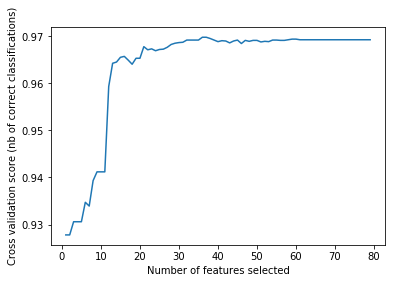

In [241]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
kf = KFold(n_splits=5, shuffle=True, random_state=100)
X = engineered_data.loc[:, engineered_data.columns != target]
y = engineered_data.loc[:, target]

logreg = LogisticRegression(solver='lbfgs', max_iter=250,random_state=100)
rfe = RFECV(logreg, cv =kf,scoring='accuracy')
rfe = rfe.fit(X, y)

Selected_Features = list(engineered_data.loc[:, rfe.support_])
Selected_Features.remove('left')
print('Selected features: {}'.format(list(engineered_data.loc[:, rfe.support_])))




print("Optimal number of features : %d" % rfe.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [242]:
target='left'
X = engineered_data.loc[:,  Selected_Features]
y = engineered_data.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            
                                                    test_size=0.2, 
                                                    random_state=100)
Kscore , L_fit = get_best_fit(X_train, y_train, 10)

[diff: 0.9633] changed
[diff: 0.9550] [diff: 0.9592] [diff: 0.9575] [diff: 0.9625] [diff: 0.9583] [diff: 0.9633] [diff: 0.9508] [diff: 0.9675] changed
[diff: 0.9508] The highest accuracy score from the K_folds obtained at K: 9.000 id 0.968


In [243]:
final_score = L_fit.score(X_test,y_test)
final_score

0.95999999999999996

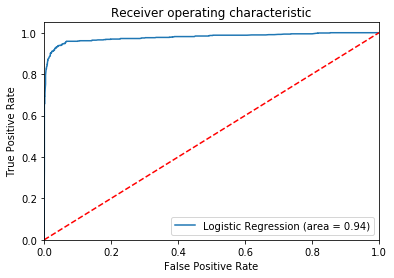

[[2204   46]
 [  74  676]]
             precision    recall  f1-score   support

          0       0.97      0.98      0.97      2250
          1       0.94      0.90      0.92       750

avg / total       0.96      0.96      0.96      3000



In [244]:
y_pred = L_fit.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, L_fit.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))